<a target="_blank" href="https://colab.research.google.com/github/ZHAW-ZAV/TSO-FS25-students/blob/main/06_supervised_ml/rway_prediction_A321.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Exercise: Predicting Runway Choice for A321 Departures at Zurich Airport

**Objective:**  
Your task is to design and build a machine learning (ML) model that predicts whether an Airbus A321 departing from Zurich Airport (ZRH) will take off from Runway 28 or Runway 16. The prediction should be made in advance, based on relevant data features you identify.

**Background:**  
Zurich Airport has multiple runways, but the choice of runway for departing flights like the A321—a medium-sized aircraft—can significantly impact airport operations:  
- **Runway 28**: Shorter taxiing distance, allowing quicker departures. It operates independently of other runways, making it efficient for scheduling.  
- **Runway 16**: Longer runway, typically reserved for heavier aircraft due to its length. However, it cannot operate independently of Runway 14 (used for landings). When an aircraft is landing on Runway 14, departures on Runway 16 must wait, potentially causing delays and reducing airport capacity.  

The A321 is a versatile aircraft: when lightly loaded, it can use Runway 28, but when heavily loaded (e.g., with more passengers, cargo, or fuel), it may require Runway 16 for a safer takeoff. Currently, the runway request is made by the airline or pilot closer to departure, which limits the airport’s ability to optimize planning.

**Why It Matters:**  
Predicting the runway choice in advance offers significant value for airport operations:  
- **Improved Efficiency**: Knowing early whether an A321 will use Runway 28 or 16 helps optimize taxiing routes and departure sequencing, reducing ground delays.  
- **Capacity Management**: Avoiding unnecessary use of Runway 16 minimizes conflicts with landings on Runway 14, preserving overall airport throughput.  
- **Resource Planning**: Accurate predictions allow better allocation of gates, ground crew, and equipment based on expected taxiing times and runway usage.  

**Your Task:**  
1. Identify potential data inputs (features) that could influence the A321’s runway
2. Build a simple ML model
3. Evaluate the model

## Dataset loading

The dataset is a csv file stored on a google drive.
You will load it into a pandas dataframe.



In [1]:
import pandas as pd
file_id = "1bKB2Fkt-iRQTS06zZ-YKkPUsQPuuyj_T"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url)
df.head()

,icao24,callsign,timestamp,runway,dest_max,dist_lszh,typecode,temperature,pressure,tailwind_16,tailwind_28,wind_gust
0,4b168f,SWR185N,2018-01-01 08:59:28+00:00,28,LGAV,1989.017568,A321,5.0,1015.0,3.500000,3.500000,NaN
1,461fa4,FIN8PY,2018-01-01 10:04:38+00:00,28,EFHK,2278.074743,A321,6.0,1015.0,4.446262,8.356239,NaN
2,4baa8e,THY9SC,2018-01-01 10:20:24+00:00,28,LTFM,2337.168213,A321,6.0,1014.0,5.814342,10.927389,NaN
3,4b1696,SWR43B,2018-01-01 11:27:53+00:00,16,EGLL,1096.085110,A321,7.0,1013.0,2.257426,9.958578,NaN
4,4b1698,SWR204K,2018-01-01 11:29:38+00:00,16,LPPR,2035.584651,A321,7.0,1013.0,2.257426,9.958578,NaN


## Explorary Data Analysis

In [2]:
df['runway'].value_counts()

runway
28    21110
16     7135
Name: count, dtype: int64

In [3]:
df['from_16'] = (df['runway']==16).astype(int)
df.from_16.value_counts()

from_16
0    21110
1     7135
Name: count, dtype: int64

### Correlation plot for numerical variables

In [4]:
import plotly.express as px
# plot correlation matrix
corr_matrix = df[['dist_lszh', 'temperature', 'pressure', 'tailwind_16', 'tailwind_28', 'wind_gust', 'from_16']].corr()
fig = px.imshow(
    corr_matrix,
    text_auto=True,  # display correlation values on the heatmap
    aspect="auto",
    color_continuous_scale="RdBu",
    range_color=[-1,1],
    
    title="Correlation Heatmap of Aircraft Data",
    height=600,
    width=600
)
fig.show()

### Categorical variables

Let's have a look at the top 20 callsigns:

In [5]:
top20cs = df.callsign.value_counts().head(20).index
subset = df.query("callsign in @top20cs")
subset.groupby('callsign').agg({'from_16':['count', 'mean'], 'dest_max':'first'}).sort_values(('from_16', 'mean'), ascending=False)

from_16           dest_max
           count      mean    first
callsign                           
SWR204K      314  0.853503     LPPR
SWR204M      390  0.810256     LPPT
SWR219J      513  0.771930     LEMG
SWR42H       413  0.738499     EIDW
SWR106Y      416  0.668269     LGAV
SWR185N      602  0.616279     LGAV
SWR248M      472  0.569915     LEMG
SWR1956      305  0.445902     LEBL
SWR131C      638  0.423197     LEBL
SWR218L      417  0.364508     LEPA
SWR129L      349  0.361032     EKCH
SWR125B      301  0.318937     EKCH
SWR734       405  0.224691     EHAM
SWR198F      600  0.138333     LEBL
SWR31J       413  0.101695     EGLL
TAP927M      479  0.060543     LPPR
FIN8PY       473  0.006342     EFHK
FIN6KP       536  0.005597     EFHK
AEE5ZH       437  0.002288     LGAV
SWR83GR      535  0.001869     LSGG

Let's have a look at the top 20 destinations:

In [6]:
top20dest = df.dest_max.value_counts().head(20).index
subset = df.query("dest_max in @top20dest")
subset.groupby('dest_max').agg({'from_16':['count', 'mean']}).sort_values(('from_16', 'mean'), ascending=False)

from_16          
           count      mean
dest_max                  
EIDW         461  0.704989
LEMG        1324  0.642749
ESSA         536  0.567164
LPPR         474  0.527426
LGAV        1341  0.501119
LPPT        1849  0.447810
LQSA         464  0.346983
LEBL        2417  0.304510
LEPA        1284  0.271028
EKCH        1191  0.247691
EHAM         894  0.168904
EDDH         959  0.163712
LIRF         717  0.132497
EDDB         830  0.112048
LOWW         980  0.096939
EGLL        1646  0.070474
LTFM        2512  0.044984
EDDF         744  0.025538
LSGG        1211  0.020644
EFHK        1011  0.005935

## Preparing the dataset

Using the scikit learn library, we will create a training and testing dataset:

In [7]:
from sklearn.model_selection import train_test_split
# Convert categorical features to dummy variables
categorical_features = ['callsign', 'dest_max']
df_features = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Define features including numeric ones and all dummy columns from 'callsign' and 'dest_max'
features = [
    "temperature",
    "pressure",
    "tailwind_28",
    "tailwind_16",
    "dist_lszh"
] + [c for c in df_features.columns if c.startswith('callsign_') or c.startswith('dest_max_')]

# Define features and target variable
X = df_features[features]
y = df_features["from_16"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19771, 948), (19771,), (8474, 948), (8474,))

## Training the model

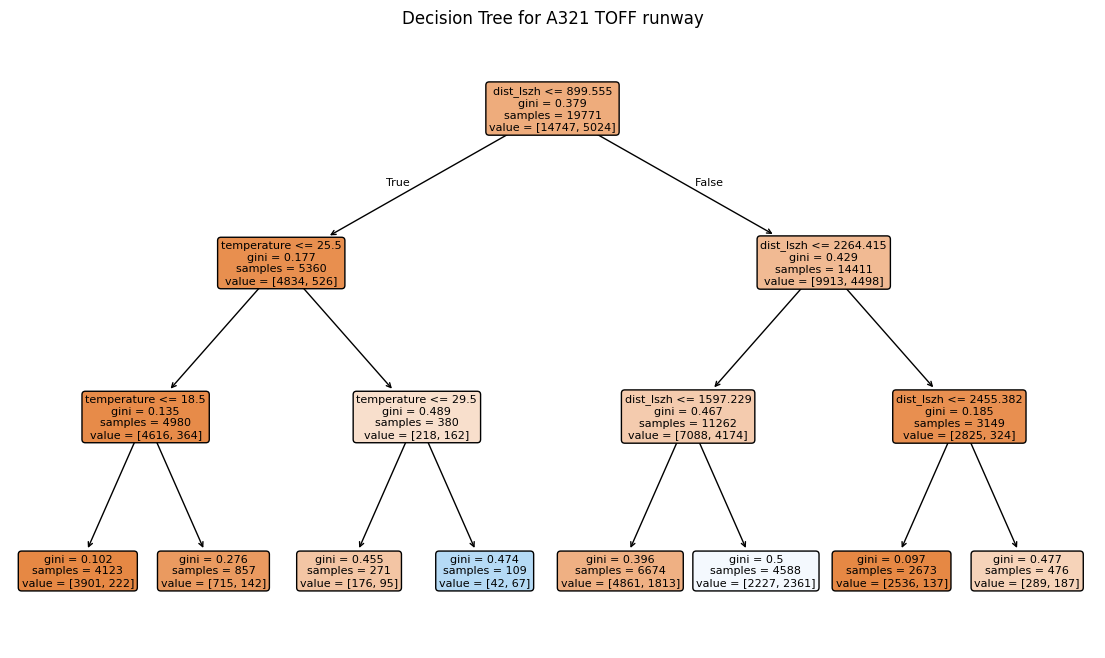

In [8]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

tree_reg = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_reg.fit(X_train, y_train)


# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree_reg, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree for A321 TOFF runway 16")
plt.show()
# print the confustion matrix


## Model Evaluation

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = tree_reg.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# We can print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[5346 1017]
 [1082 1029]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6363
           1       0.50      0.49      0.50      2111

    accuracy                           0.75      8474
   macro avg       0.67      0.66      0.67      8474
weighted avg       0.75      0.75      0.75      8474



# Task 1:Implement Recall, Precision and F1 Score by yourself

# Task 2: 
- Change the model to predict the probability of using runway 16.
- With plotly create a visualization to visualize the probability of the false positive and false negative ones.

# Task 3: Now it's your turn to train a model!

Tips:
- Build some new relevant feature
- Fine tune the ML model
- Best F1 score wins!
